In [1]:
using Crystalline, MPBUtils, JLD2, PyPlot, DelimitedFiles, SymmetryBases
using Crystalline: TEST_αβγs
using Crystalline: TEST_αβγ
using Brillouin
using Crystalline: dot
using Crystalline: norm

In [29]:
#Make more fine kmesh along high symmetry path
D, sg = 2, 10
cntr = centering(sg, D)
Rs = directbasis(sg, Val(D))
Gs = reciprocalbasis(Rs)
pRs = primitivize(Rs, cntr)
kpaths = interpolate(irrfbz_path(sg, pRs, 2),  12000).kpaths
allkpaths = Vector{Vector{Float64}}()
for kpath in kpaths
    for k in kpath
        push!(allkpaths, k)
    end
end
# kpoints file for dispersion calculation
#=open("./dispersions/input/kpoints.dat", "w") do io
    for kvec in allkpaths
        write(io, "($(kvec[1]) $(kvec[2])) ")
    end
end=#

In [77]:
#This is the 501x501 kmesh we use for the nodal point calculations
#
ks = Vector{Vector{Float64}}()
N = 500
for i in 1:N+1
for j in 1:N+1
    kx = (i-1)/N - 0.5
    ky = (j-1)/N - 0.5
    push!(ks, [kx, ky])
end
end
#=for idx in 1:200
    open("./nodal_points/input/kpoints-$idx.dat", "w") do io
        write(io, "(")
        for k in ks[idx:200:length(ks)]
            write(io, "($(k[1]) $(k[2])) ")
        end
        write(io, ")")
    end
end=#

In [99]:
bands3 = Vector{Vector{Float64}}();
bands4 = Vector{Vector{Float64}}();
calc_idxs = [28159, 27163, 22488, 21548, 27021, 25243, 21152, 23742, 28064, 29229, 20772, 29939, 28545, 20132]
for calcidx in calc_idxs
    println("Calcidx: $calcidx"); flush(stdout)
    band3 = zeros(501*501)
    band4 = zeros(501*501)
    all_bands = zeros(501*501, 11)
    for idx in 1:200
        #(idx % 20 == 0 ) && println(idx); flush(stdout)
        top_band = 3
        res = (calcidx ∈ [20132, 28545, 29939, 27163]) ? 64 : 32  # Need higher resolution for three of the calculations
        dispersion = readdlm("nodal_points/output/output_$calcidx/dim2-sg10-$calcidx-res$(res)-te-$idx-dispersion.out", ',', Float64)
        #dispersion = readdlm("nodal_points/output/dim2-sg10-23742-res32-te-$idx-dispersion.out", ',', Float64)
        #dispersion = readdlm("nodal_points/output/dim2-sg10-27163-res32-te-$idx-dispersion.out", ',', Float64)
        dispersion = sort(dispersion[:, 6:end], dims = 2)
        lower_dispersion = dispersion[:, top_band]
        upper_dispersion = dispersion[:, top_band+1]
        gap = minimum(upper_dispersion - lower_dispersion)
        gap < 0 && (println("Negative Gap at idx: $idx"); flush(stdout); println(argmin(upper_dispersion - lower_dispersion)))
        band3[idx:200:end] =  lower_dispersion 
        band4[idx:200:end] =  upper_dispersion 
    end
    push!(bands3, band3)
    push!(bands4, band4)
end

Calcidx: 28159
Calcidx: 27163
Calcidx: 22488
Calcidx: 21548
Calcidx: 27021
Calcidx: 25243
Calcidx: 21152
Calcidx: 23742
Calcidx: 28064
Calcidx: 29229
Calcidx: 20772
Calcidx: 29939
Calcidx: 28545
Calcidx: 20132


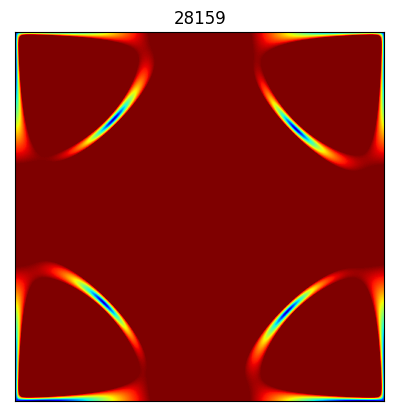

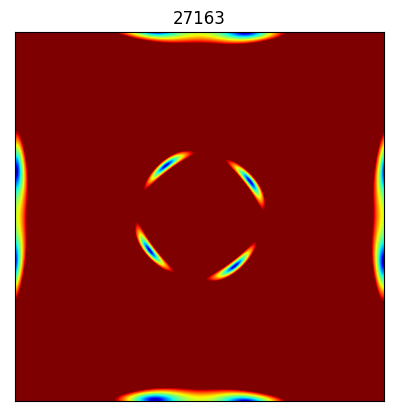

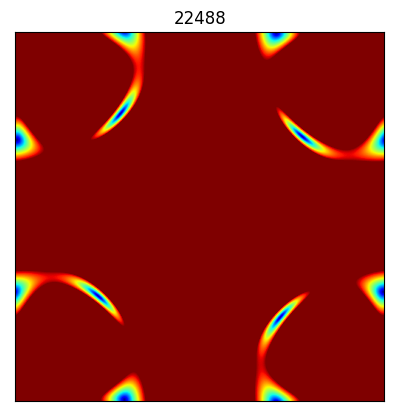

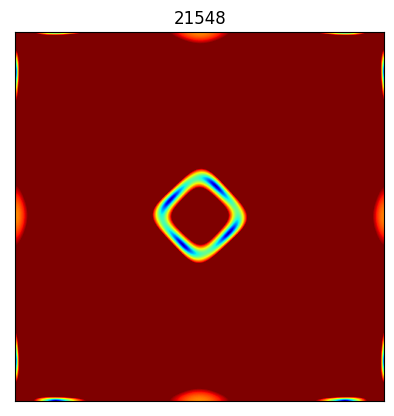

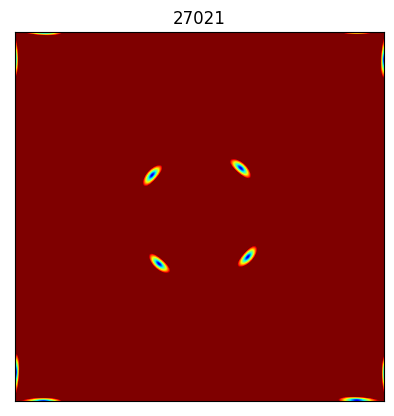

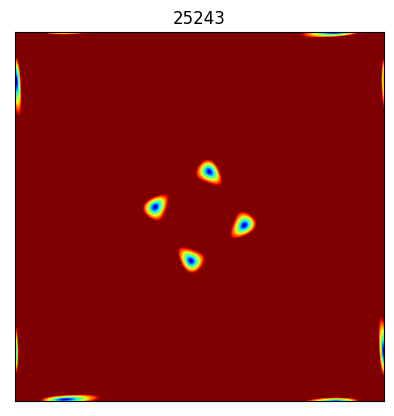

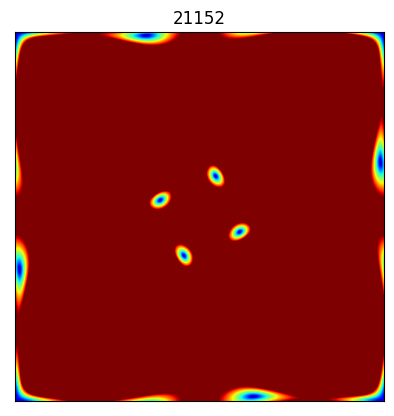

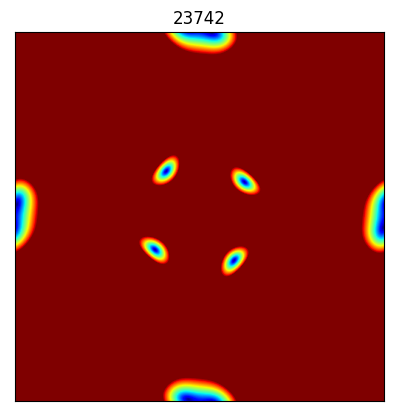

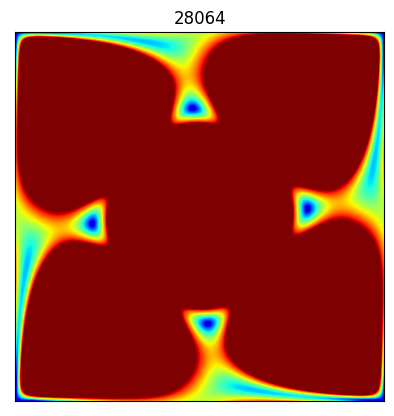

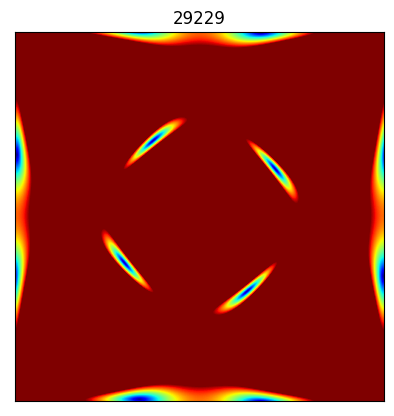

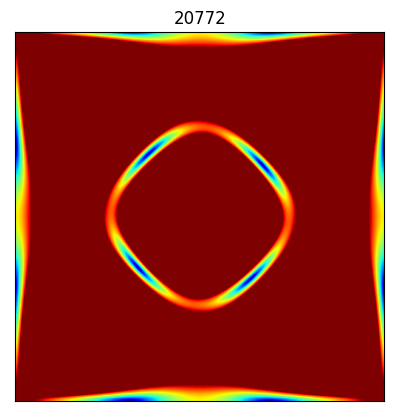

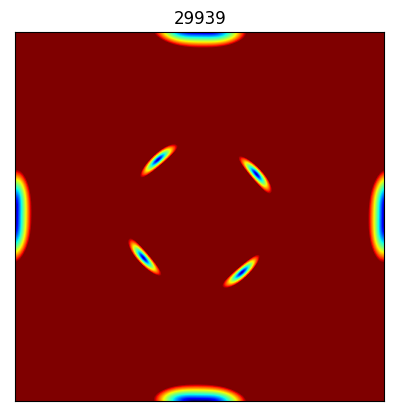

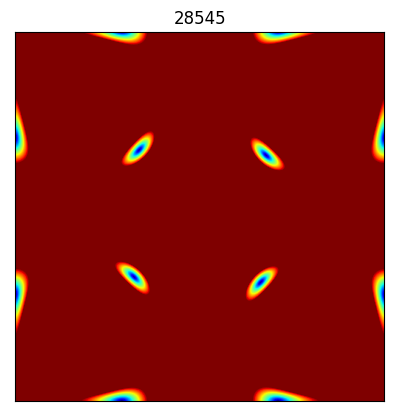

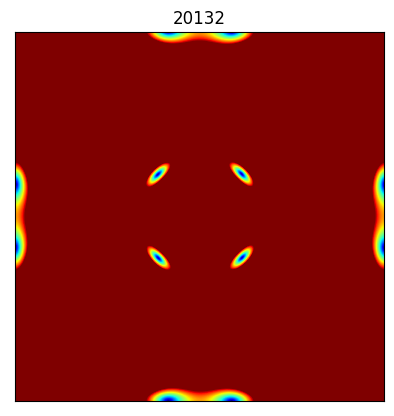

In [100]:
for (calc_idx, band3, band4) in zip(calc_idxs, bands3, bands4)
    figure()
    imshow(reshape(band4-band3, (501, 501)), vmax=0.5e-2, vmin=1e-5, cmap="jet")
    xticks([])
    yticks([])
    title(calc_idx)
end

In [112]:
first_nodal_points = Vector{Float64}[]
second_nodal_points = Vector{Float64}[]

for (calc_idx, band3, band4) in zip(calc_idxs, bands3, bands4)
    near_nodal_points = filter( x-> x[1] > 0 && x[2] > 0, ks[sortperm(band4 - band3)])
    first_nodal_point = near_nodal_points[1] 
    second_nodal_point_candidates = filter(x->norm(x-first_nodal_point) > 1/5, near_nodal_points)
    if (first_nodal_point[1] ≈ 0.5 || first_nodal_point[2] ≈ 0.5)
        second_nodal_point_candidates = filter(x-> !(x[1] ≈ 0.5) && !(x[2] ≈ 0.5), second_nodal_point_candidates)
    end
    second_nodal_point = first(second_nodal_point_candidates)
    first_nodal_point = round.(first_nodal_point, digits=5)
    second_nodal_point = round.(second_nodal_point, digits=5)
    push!(first_nodal_points, first_nodal_point)
    push!(second_nodal_points, second_nodal_point)
    println("Calcidx: $calc_idx, Nodal points: $first_nodal_point, $second_nodal_point")
end

Calcidx: 28159, Nodal points: [0.5, 0.42], [0.236, 0.26]
Calcidx: 27163, Nodal points: [0.496, 0.122], [0.094, 0.136]
Calcidx: 22488, Nodal points: [0.496, 0.206], [0.216, 0.276]
Calcidx: 21548, Nodal points: [0.5, 0.392], [0.078, 0.046]
Calcidx: 27021, Nodal points: [0.13, 0.11], [0.424, 0.498]
Calcidx: 25243, Nodal points: [0.12, 0.026], [0.496, 0.366]
Calcidx: 21152, Nodal points: [0.144, 0.488], [0.108, 0.042]
Calcidx: 23742, Nodal points: [0.496, 0.032], [0.092, 0.12]
Calcidx: 28064, Nodal points: [0.02, 0.292], [0.456, 0.498]
Calcidx: 29229, Nodal points: [0.496, 0.162], [0.128, 0.204]
Calcidx: 20772, Nodal points: [0.19, 0.5], [0.138, 0.17]
Calcidx: 29939, Nodal points: [0.5, 0.016], [0.114, 0.152]
Calcidx: 28545, Nodal points: [0.5, 0.212], [0.164, 0.18]
Calcidx: 20132, Nodal points: [0.5, 0.086], [0.114, 0.112]


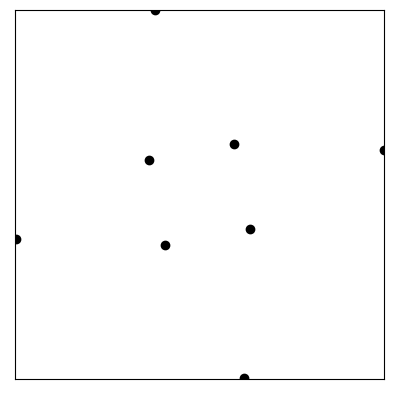

In [32]:
# Nodal points for 27163
scatter(-0.498, -0.12, color="black")
scatter(0.498, 0.12, color="black")
scatter(0.12, -0.498, color="black")
scatter(-0.12, 0.498, color="black")

scatter(0.0934, 0.136, color="black")
scatter(-0.0934, -0.136, color="black")
scatter(-0.136, 0.0934, color="black")
scatter(0.136, -0.0934, color="black")

xlim(-0.5, 0.5)
ylim(-0.5, 0.5)
gca().set_aspect("equal", adjustable="box")
xticks([])
yticks([]);

In [113]:
#This is the 501x501 kmesh we use for the (possible) nodal point calculations
#
ks = Vector{Vector{Float64}}()
#N = 100
N = 200
for i in 1:N+1
    kx = -0.5 + (i-1)/N
    ky = -0.5
    push!(ks, [kx, ky])
end
for i in 1:N
    kx = 0.5 
    ky = -0.5 + i/N
    push!(ks, [kx, ky])
end
for i in 1:N
    kx = 0.5 - i/N
    ky = 0.5
    push!(ks, [kx, ky])
end
for i in 1:N
    kx = -0.5 
    ky = 0.5 - i/N
    push!(ks, [kx, ky])
end
#=
open("./wilson_loops/input/kpoints.sh", "w") do io
    write(io, "berry-ks-loops=(list (list ")
    for k in ks
        k_scaled_x = k[1]*1/20 - 0.498
        k_scaled_y = k[2]*1/20 - 0.12
        write(io, "(vector3 $(k_scaled_x) $(k_scaled_y)) ")
    end
    write(io, ") (list ")
    for k in ks
        k_scaled_x = k[1]*1/20 + 0.09399999999999997
        k_scaled_y = k[2]*1/20 + 0.136
        write(io, "(vector3 $(k_scaled_x) $(k_scaled_y)) ")
    end
    write(io, ") (list ")
    for k in ks
        k_scaled_x = k[1]*1/20 + 0.498
        k_scaled_y = k[2]*1/20 + 0.12
        write(io, "(vector3 $(k_scaled_x) $(k_scaled_y)) ")
    end
    write(io, ") (list ")
    for k in ks
        k_scaled_x = k[1]*1/2 + 1/4
        k_scaled_y = k[2]*1/2 + 1/4
        write(io, "(vector3 $(k_scaled_x) $(k_scaled_y)) ")
    end
    write(io, "))")
end;=#

In [114]:
for (calc_idx, first_nodal_point, second_nodal_point) in zip(calc_idxs, first_nodal_points, second_nodal_points)
    fx, fy = first_nodal_point
    sx, sy = second_nodal_point
    open("./wilson_loops/input/kpoints-$calc_idx.sh", "w") do io
        write(io, "berry-ks-loops=(list (list ")
        for k in ks
            k_scaled_x = k[1]*1/100 - fx
            k_scaled_y = k[2]*1/100 - fy
            write(io, "(vector3 $(k_scaled_x) $(k_scaled_y)) ")
        end
        write(io, ") (list ")
        for k in ks
            k_scaled_x = k[1]*1/100 + sx
            k_scaled_y = k[2]*1/100 + sy
            write(io, "(vector3 $(k_scaled_x) $(k_scaled_y)) ")
        end
        write(io, ") (list ")
        for k in ks
            k_scaled_x = k[1]*1/100 + fx
            k_scaled_y = k[2]*1/100 + fy
            write(io, "(vector3 $(k_scaled_x) $(k_scaled_y)) ")
        end
        write(io, ") (list ")
        for k in ks
            k_scaled_x = k[1]*1/2 + 1/4
            k_scaled_y = k[2]*1/2 + 1/4
            write(io, "(vector3 $(k_scaled_x) $(k_scaled_y)) ")
        end
        write(io, "))")
    end;
end

In [73]:
first_nodal_points

14-element Vector{Vector{Float64}}:
 [0.5, 0.42]
 [0.496, 0.122]
 [0.496, 0.206]
 [0.5, 0.392]
 [0.13, 0.11]
 [0.12, 0.026]
 [0.144, 0.488]
 [0.496, 0.032]
 [0.02, 0.292]
 [0.496, 0.162]
 [0.19, 0.5]
 [0.108, 0.15]
 [0.19, 0.5]
 [0.106, 0.106]

In [115]:
for calc_idx in calc_idxs
    res = 32
    (calc_idx ∈ [20132, 28545, 29939, 27163]) && (res = 64)
berry_phases = readdlm("wilson_loops/output/dim2-sg10-$calc_idx-res$res-te-phases.out", ',')[:, 7:end] ./ π
berry_phases = round.(berry_phases, digits=3)

# Berry phase for bands 1-3
println("Calcidx: $calc_idx, Berry phases for the two loops: ", reshape(sum(berry_phases[:, 3:5], dims=2), (1, 4)))
end

Calcidx: 28159, Berry phases for the two loops: [-1.0 1.0 -1.0 0.0]
Calcidx: 27163, Berry phases for the two loops: [-1.0 1.0 -1.0 0.0]
Calcidx: 22488, Berry phases for the two loops: [-1.0 1.0 -1.0 0.0]
Calcidx: 21548, Berry phases for the two loops: [1.0 1.0 1.0 0.0]
Calcidx: 27021, Berry phases for the two loops: [1.0 1.0 -1.0 0.0]
Calcidx: 25243, Berry phases for the two loops: [1.0 -1.0 1.0 0.0]
Calcidx: 21152, Berry phases for the two loops: [-1.0 1.0 1.0 0.0]
Calcidx: 23742, Berry phases for the two loops: [-1.0 -1.0 1.0 0.0]
Calcidx: 28064, Berry phases for the two loops: [1.0 1.0 -1.0 0.0]
Calcidx: 29229, Berry phases for the two loops: [-1.0 -1.0 -1.0 0.0]
Calcidx: 20772, Berry phases for the two loops: [1.0 -1.0 1.0 0.0]
Calcidx: 29939, Berry phases for the two loops: [1.0 -1.0 -1.0 0.0]
Calcidx: 28545, Berry phases for the two loops: [-1.0 -1.0 -1.0 0.0]
Calcidx: 20132, Berry phases for the two loops: [-1.0 1.0 -1.0 0.0]


In [97]:
berry_phases = readdlm("wilson_loops/output/dim2-sg10-27163-res64-te-phases.out", ',')[:, 7:end] ./ π
berry_phases = round.(berry_phases, digits=3)

# Berry phase for bands 1-3
println("Berry phases for the two loops: ", reshape(sum(berry_phases[:, 3:5], dims=2), (1, 4)))

Berry phases for the two loops: [-1.0 1.0 -1.0 0.0]


In [100]:
berry_phases = readdlm("wilson_loops/output/dim2-sg10-23742-res32-te-phases.out", ',')[:, 7:end] ./ π
berry_phases = round.(berry_phases, digits=3)

# Berry phase for bands 1-3
println("Berry phases for the two loops: ", reshape(sum(berry_phases[:, 3:5], dims=2), (1, 4)))

Berry phases for the two loops: [-1.0 -1.0 1.0 0.0]


In [4]:
dir = "./symeigs/output"

symeigsdv = Dict{Integer, Dict{String, Vector{Vector{ComplexF64}}}}()
summariesv = Dict{Integer, Vector{BandSummary}}()
cumsummariesv = Dict{Integer, Vector{BandSummary}}()

mode = "te"
brs = bandreps(10, 2)
for id in [20132,20772,21152,21548,22488,23742,25243,27021,27163,28064,28159,28545,29229,29939]
    println(id); flush(stdout)
    symeigsd, lgd = read_symdata("dim2-sg10-$(id)-res192-$mode", dir = dir)
    fixup_gamma_symmetry!(symeigsd, lgd, Symbol(uppercase(mode)))
    lgirsd = pick_lgirreps(lgd)
    
    push!(symeigsdv, id => symeigsd)
    summaries = analyze_symmetry_data(symeigsd, lgirsd, brs)            
    push!(summariesv, id  => summaries)
    push!(cumsummariesv, id => cumsum(summaries))
end

20132
20772
21152
21548
22488
23742
25243
27021
27163
28064
28159
28545
29229
29939


In [6]:
for (id, cumsummaries) in cumsummariesv
    println(id) 
    println(filter(x -> x.topology == FRAGILE, cumsummaries))
end

21152
BandSummary[3-band (fragile): [X₁+2X₂, M₁+M₃M₄, 3Γ₁]]
22488
BandSummary[3-band (fragile): [X₁+2X₂, M₁+M₃M₄, 3Γ₁]]
23742
BandSummary[3-band (fragile): [X₁+2X₂, M₁+M₃M₄, 3Γ₁]]
20132
BandSummary[3-band (fragile): [2X₁+X₂, M₂+M₃M₄, 3Γ₁]]
27021
BandSummary[3-band (fragile): [2X₁+X₂, M₂+M₃M₄, 3Γ₁]]
28545
BandSummary[3-band (fragile): [X₁+2X₂, M₁+M₃M₄, 3Γ₁]]
25243
BandSummary[3-band (fragile): [X₁+2X₂, M₁+M₃M₄, 3Γ₁]]
20772
BandSummary[3-band (fragile): [X₁+2X₂, M₁+M₃M₄, 3Γ₁]]
28064
BandSummary[3-band (fragile): [X₁+2X₂, M₁+M₃M₄, 3Γ₁]]
29939
BandSummary[3-band (fragile): [2X₁+X₂, M₂+M₃M₄, 3Γ₁]]
27163
BandSummary[3-band (fragile): [2X₁+X₂, M₂+M₃M₄, 3Γ₁]]
21548
BandSummary[3-band (fragile): [2X₁+X₂, M₂+M₃M₄, 3Γ₁]]
28159
BandSummary[3-band (fragile): [2X₁+X₂, M₂+M₃M₄, 3Γ₁]]
29229
BandSummary[3-band (fragile): [2X₁+X₂, M₂+M₃M₄, 3Γ₁]]


In [16]:
[x for (x, _) in cumsummariesv]

14-element Vector{Int64}:
 21152
 22488
 23742
 20132
 27021
 28545
 25243
 20772
 28064
 29939
 27163
 21548
 28159
 29229

In [8]:
# Get BRS decomposition
brs = bandreps(10, 2);
brs_labs = ["(" * br.wyckpos * "|"  * prod(string.(collect(br.label)[1:end-2])) * ")" for br in brs];

In [26]:
brs_decomps = broadcast((x, y) -> decompose(x, y), [x[2].n for (_, x) in cumsummariesv], [x[2].brs for (_, x) in cumsummariesv])
brs_decomps = Crystalline.symvec2string.(brs_decomps, Ref(brs_labs))

14-element Vector{String}:
 "[(2c|A)+(1b|A)+(1a|A)-(1a|B)]"
 "[(2c|A)+(1b|A)+(1a|A)-(1a|B)]"
 "[(2c|A)+(1b|A)+(1a|A)-(1a|B)]"
 "[(2c|A)+(1b|A)-(1b|B)+(1a|A)]"
 "[(2c|A)+(1b|A)-(1b|B)+(1a|A)]"
 "[(2c|A)+(1b|A)+(1a|A)-(1a|B)]"
 "[(2c|A)+(1b|A)+(1a|A)-(1a|B)]"
 "[(2c|A)+(1b|A)+(1a|A)-(1a|B)]"
 "[(2c|A)+(1b|A)+(1a|A)-(1a|B)]"
 "[(2c|A)+(1b|A)-(1b|B)+(1a|A)]"
 "[(2c|A)+(1b|A)-(1b|B)+(1a|A)]"
 "[(2c|A)+(1b|A)-(1b|B)+(1a|A)]"
 "[(2c|A)+(1b|A)-(1b|B)+(1a|A)]"
 "[(2c|A)+(1b|A)-(1b|B)+(1a|A)]"

In [27]:
unique(brs_decomps)

2-element Vector{String}:
 "[(2c|A)+(1b|A)+(1a|A)-(1a|B)]"
 "[(2c|A)+(1b|A)-(1b|B)+(1a|A)]"

In [11]:
dispersions = Dict{Integer, Matrix{Float64}}()
for id in [20132,20772,21152,21548,22488,23742,25243,27021,27163,28064,28159,28545,29229,29939]
    push!(dispersions, id => readdlm("../../dispersions/output/sg10/eps3/te/dim2-sg10-$id-res64-te-dispersion.out", ',') )
end

In [27]:
jldopen("cumfragiledata.jld2", "w") do fid
    fid["dispersions"] = dispersions
    fid["symeigsdv"] = symeigsdv
    fid["summariesv"] = summariesv
    fid["cumsummariesv"] = cum_summariesv
end

Dict{Integer, Vector{BandSummary}} with 14 entries:
  21152 => [2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁], 3-band (fragile): [X₁+2X₂,…
  22488 => [1-band (nontrivial): [X₂, M₁, Γ₁], 3-band (fragile): [X₁+2X₂, M₁+M₃…
  23742 => [2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁], 3-band (fragile): [X₁+2X₂,…
  20132 => [2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁], 3-band (fragile): [2X₁+X₂,…
  27021 => [1-band (trivial): [X₂, M₂, Γ₁], 3-band (fragile): [2X₁+X₂, M₂+M₃M₄,…
  28545 => [1-band (nontrivial): [X₂, M₁, Γ₁], 3-band (fragile): [X₁+2X₂, M₁+M₃…
  25243 => [2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁], 3-band (fragile): [X₁+2X₂,…
  20772 => [2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁], 3-band (fragile): [X₁+2X₂,…
  28064 => [2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁], 3-band (fragile): [X₁+2X₂,…
  29939 => [2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁], 3-band (fragile): [2X₁+X₂,…
  27163 => [2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁], 3-band (fragile): [2X₁+X₂,…
  21548 => [2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁], 3-ba

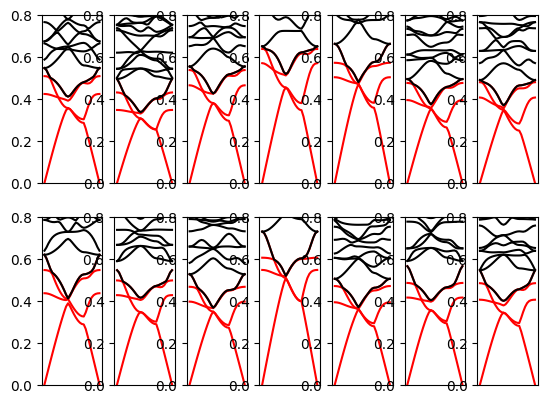

In [12]:
for (i, id) in enumerate([20132,20772,21152,21548,22488,23742,25243,27021,27163,28064,28159,28545,29229,29939])
    subplot(2, 7, i)
    bands = dispersions[id]
    plot(bands[:, 6:(3 .+ 6)], color="red")
    plot(bands[:, (3 .+ 6):end], color="black")
    ylim(0, 0.8)
    xticks([])
end    

In [ ]:
# figure(figsize=(20, 10))
for (i, id) in enumerate([20132,20772,21152,21548,22488,23742,25243,27021,27163,28064,28159,28545,29229,29939])
    subplot(2, 7, i)
    bands = dispersions[id]
    plot(bands[:, 6:(3 .+ 6)], color="red")
    plot(bands[:, (3 .+ 6):end], color="black")

    ylim(0, 0.8)
    xticks([])
    xticks([0, 12, 20, 28], ["Γ", "M", "X", "Γ"])
    xlim(0, 28)
    title(id)
end    
suptitle("Band Structrues of Cumulatively Fragile Structures")


In [14]:
id = 27163
bands192 = readdlm("./dispersions/output/dim2-sg10-$id-res192-te-dispersion.out", ',')[:, 6:end]
bands128 = readdlm("./dispersions/output/dim2-sg10-$id-res128-te-dispersion.out", ',')[:, 6:end]
bands32 = readdlm("./dispersions/output/dim2-sg10-$id-res32-te-dispersion.out", ',')[:, 6:end]
bands16 = readdlm("./dispersions/output/dim2-sg10-$id-res16-te-dispersion.out", ',')[:, 6:end];
bands64 = readdlm("./dispersions/output/dim2-sg10-$id-res64-te-dispersion.out", ',')[:, 6:end];
bands256 = readdlm("./dispersions/output/dim2-sg10-$id-res256-te-dispersion.out", ',')[:, 6:end];
bands20 = readdlm("./dispersions/output/dim2-sg10-$id-res20-te-dispersion.out", ',')[:, 6:end];
bands24 = readdlm("./dispersions/output/dim2-sg10-$id-res24-te-dispersion.out", ',')[:, 6:end];
bands28 = readdlm("./dispersions/output/dim2-sg10-$id-res28-te-dispersion.out", ',')[:, 6:end];
bands30 = readdlm("./dispersions/output/dim2-sg10-$id-res30-te-dispersion.out", ',')[:, 6:end];


In [5]:
min64 = minimum(bands64[:, 4]  - bands64[:, 3])
min16 = minimum(bands16[:, 4]  - bands16[:, 3])
min20 = minimum(bands20[:, 4]  - bands20[:, 3])
min28 = minimum(bands28[:, 4]  - bands28[:, 3])
min30 = minimum(bands30[:, 4]  - bands30[:, 3])

min24 = minimum(bands24[:, 4]  - bands24[:, 3])
min32 = minimum(bands32[:, 4]  - bands32[:, 3])
min128 = minimum(bands128[:, 4]  - bands128[:, 3])
min192 = minimum(bands192[:, 4]  - bands192[:, 3])
min256 = minimum(bands256[:, 4]  - bands256[:, 3])


0.00046199999999996244

In [17]:
kpaths[1][argmin(bands256[:, 4] - bands256[:, 3])]

2-element StaticArrays.SVector{2, Float64} with indices SOneTo(2):
 0.11895276038702332
 0.5

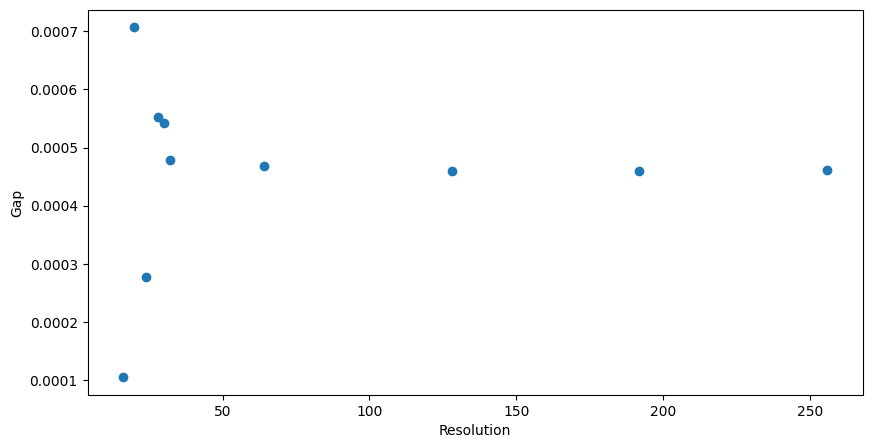

PyObject Text(24.0, 0.5, 'Gap')

In [6]:
figure(figsize=(10,5))
scatter([16, 20, 24, 28, 30, 32, 64, 128, 192, 256], [min16, min20, min24, min28, min30, min32, min64, min128, min192, min256])
xlabel("Resolution")
ylabel("Gap")
#xlim(10, 80)
#ylim(0, 0.1)

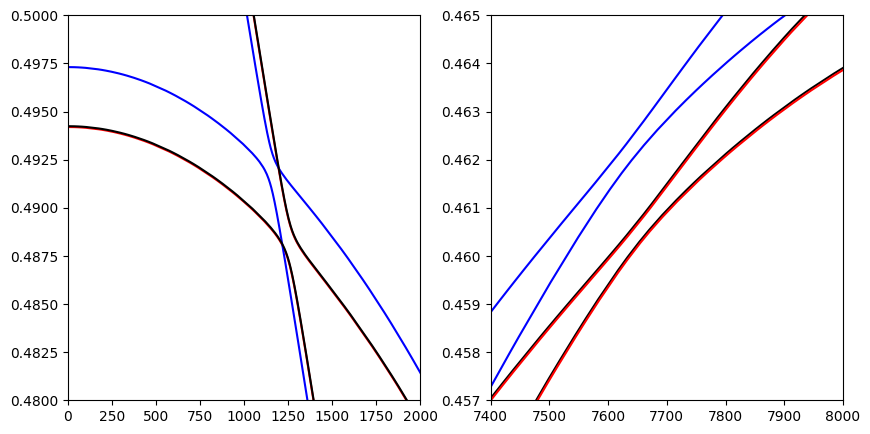

(7400.0, 8000.0)

In [26]:
figure(figsize=(10, 5))
subplot(1, 2, 1)
plot(bands192, color="red", label="192x192")
plot(bands32, color="blue", label="128x128")
plot(bands256, color="black", label="192x192")
#plot(bands16, color="black")
#plot(bands64, color="green")

xlim(0, 2000)
ylim(0.48, 0.5)
subplot(1,2,2)
plot(bands256, color="black", label="192x192")
plot(bands192, color="red", label="192x192")
plot(bands32, color="blue", label="128x128")
#plot(bands16, color="black")
#plot(bands64, color="green")
ylim(0.457, 0.465)
xlim(3700*2, 4000*2)

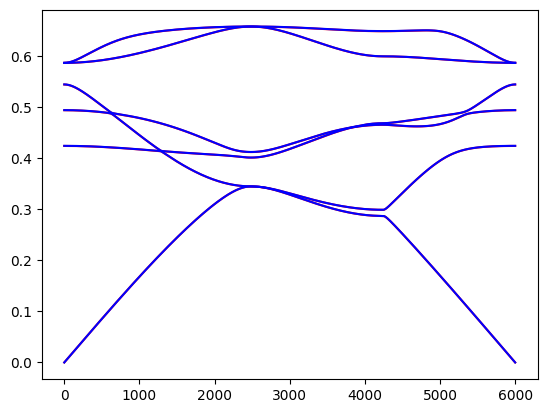

6-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f294bc014f0>
 PyObject <matplotlib.lines.Line2D object at 0x7f294bc015e0>
 PyObject <matplotlib.lines.Line2D object at 0x7f294bc016a0>
 PyObject <matplotlib.lines.Line2D object at 0x7f294bc01760>
 PyObject <matplotlib.lines.Line2D object at 0x7f294bc01820>
 PyObject <matplotlib.lines.Line2D object at 0x7f294bc018e0>

In [108]:
plot(bands192[:, :], color="red")

plot(bands128[:, :], color="blue")


In [66]:
minimum(bands16[:, 4] - bands16[:, 3])

0.00010500000000002174

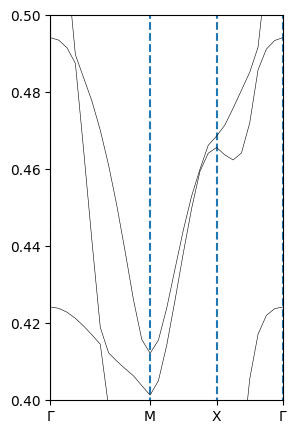

In [49]:
figure(figsize=(3, 5))
plot(bands[:, 1:4], color="black", linewidth=0.4)
xticks([0, 12, 20, 28], ["Γ", "M", "X", "Γ"])
vlines([0, 12, 20, 28], 0, 1, linestyle="dashed")
xlim(0, 28)
ylim(0.4, 0.5)
;

In [19]:
# Sweeping Epsilon

In [5]:
dir = "./symeigs/output/epsilon_sweep"

symeigsdv = Dict{Integer, Dict{String, Vector{Vector{ComplexF64}}}}()
summariesv = Dict{Integer, Vector{BandSummary}}()
cumsummariesv = Dict{Integer, Vector{BandSummary}}()

mode = "te"
brs = bandreps(10, 2)
id = 27163
for i in 1:101
    epsin = round(8+(i-1)*24/100, digits=3)

    symeigsd, lgd = read_symdata("dim2-sg10-$(id)-res192-$mode-epsin$epsin", dir = dir, sgnum=10, D=2)
    fixup_gamma_symmetry!(symeigsd, lgd, Symbol(uppercase(mode)))
    lgirsd = pick_lgirreps(lgd)
    
    push!(symeigsdv, id => symeigsd)
    summaries = analyze_symmetry_data(symeigsd, lgirsd, brs)            
    push!(summariesv, i  => summaries)
    push!(cumsummariesv, i => cumsum(summaries))
end

In [6]:
topos = TopologyKind[]
topos_imshow = zeros(101, 101)
for i in 1:101
    topology = cumsummariesv[i][2].topology
    push!(topos, topology)
    cumsummariesv[i][2].band[end] == 3 || println("More than 3 bands")
    topos_imshow[:, i]  .= 
    if topology == TRIVIAL 
            1
    elseif topology == NONTRIVIAL
        2
    elseif topology == FRAGILE
        3
    else 
        0
    end
        
end

More than 3 bands
More than 3 bands
More than 3 bands
More than 3 bands


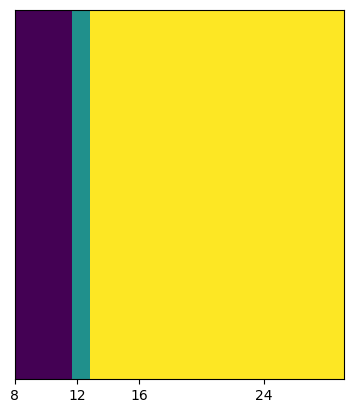

(Any[], Any[])

In [7]:
imshow(topos_imshow)
xlim(0, 90)
xticks([0, 17, 34, 68], ["8", "12", "16", "24"])
yticks(Float64[])